# LIME Explainable Binary Classification
The objective of this notebook is to train and evaluate a classifier that predicts the product category (jewelry or kitchen) from the product title, rating and review text. All operations on the data have been performed while taking care of their reproducibility and practicality.

This notebook is divided into 3 parts:
- <a href='#Part-A---Data-Preprocessing'>**Part A:** </a>
    - Data formatting, schema validation, data merging, concatenation and key-column identification
    - Label Correction 
    - Text Data Cleaning
    - K-Fold Cross Validation (5 fold splitting)
    - Time Taken: 4-5 hours (Spread over 1 day)
- <a href='#Part-B----Data-Vectorization-&-Modelling-Functions'>**Part B:**</a>
    - Defined Data Vectorization Functions 
        - Tf-Idf
        - Simple Avg. FastText Sentence Vectors
        - Tf-Idf Weighted FastText Sentence Vectors
    - Defined Models
        - Random Forest Classifier (n_estimators=10)
        - Logistic Regression
    - Defined LIME Explainer
    - Time Taken: 10 hours (Spread over 2 days)
- <a href='#Part-C----Data-Modelling'>**Part C:**</a>
    - Performed classification on various combinations of classification models (Random Forest & Logistic Regression) and feature sets. The classification model can be switched by changing a flag in Part C Model Configurations.
    - Experiment 0 : Training a Word2Vec Model using the given data corpus
    - Experiment 1 : Tf-Idf Vectorization + Classification + LIME Explanation
    - Experiment 2 : Simple Avg. FastText Sentence Vectors + Classification
    - Experiment 3 : Tf-Idf Weighted FastText Sentence Vectors + Classification
    - Time Taken: 10-12 hours (Spread over 2 days)
    
**Total Time Taken = 24-27 hours (Spread over 4 days)**

NOTE: To run this notebook in realtime, please download and save the UNZIPPED 'wiki-news-300d-1M.vec.zip' FastText Embeddings in the working directory.

- https://fasttext.cc/docs/en/english-vectors.html
- https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

# Part A - Data Preprocessing

In [1]:
# General libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from collections import defaultdict
# Text Data Cleaning liibraries
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# Data preprocessing libraries
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# Data Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
# LIME Explainer
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
# Custom sci-kit learn transformer utils
from scipy import sparse
from scipy.sparse import coo_matrix, hstack
from sklearn.base import BaseEstimator, TransformerMixin

## A.1. Importing Data

In [2]:
# Listing the content of the directory
dataList = os.listdir('dataset')

# Appending the datasets to either 'product' or review' lists
prodDFList = []
revDFList = []
for file in dataList:
    if 'products' in file.lower():
        prodDFList.append(pd.read_csv('dataset/'+file, delimiter='\t', header=None))
    elif 'reviews' in file.lower():
        revDFList.append(pd.read_csv('dataset/'+file, delimiter='\t', header=None))
    else:
        # If the filenames don't have either of the substrings, then a prompt is raised.
        print('Unidentified Data Found')

### Loading FastText Embeddings

In [3]:
# Importing FastText Embeddings
# Load the pre-trained word-embedding vectors to the dictionary
embeddings_index_all = {}
for i, line in enumerate(open('wiki-news-300d-1M.vec', encoding="utf8")):
    # if i % 1000 == 0:
    #     print(i)
    values = line.split()
    embeddings_index_all[values[0]] = np.asarray(values[1:], dtype='float32')   

### A.1.(a). Product DFs Schema Verification
Manually verifying the dataset schema by printing all the dataframes.

In [4]:
# Printing the first 5 rows of all 'product' DFs (all rows have been verified for each DF)
pIndivCount = 0
for i in prodDFList:
    pIndivCount += len(i)
    display(i.head())
print('Total number of Product rows: ', pIndivCount)

,0,1,2
0,daa54754-af9c-41c0-b542-fe5eabc5919c,Kitchen,Bodum Travel Press 12-Ounce French Press Coffe...
1,ab602aca-9bad-4aa9-bd42-6ce24cdf8680,Kitchen,RH Forschner by Victorinox BladeSafe for Knife...
2,f98cd8d3-d6fe-4ee3-8c9f-a18c1690f7a6,Kitchen,Bellemain 12-Cup Nonstick Madeleine Pan
3,396f73e3-e3ef-4c93-a4b7-e8b04c6a2223,Jewelry,8mm Heat Treated Agate Beads Tibetan Buddhist ...
4,329ed5e3-8b47-4e78-961b-18b89e7da808,Jewelry,2.50 Ct Oval Black Onyx 925 Sterling Silver Pe...


,0,1,2
0,d242fdc9-772b-4d97-94bb-dabdec22ebe7,Kitchen,iCooker® Amazing Happy Birthday Candles + FREE...
1,05d4b845-1772-4f02-8dcc-b0ef4c1e06f8,Kitchen,"Norpro 3080 Mini Measuring Spoons, 5 Piece Set"
2,b848c565-1a0b-4810-9dfc-9a537cfedcbf,Jewelry,Accessory Accomplice Silvertone Guardian Angel...
3,ae56ebfe-0abf-4a55-88fc-d838b834d4ae,Kitchen,Hamilton Beach 64650 6-Speed Classic Stand Mix...
4,1646a66b-4a17-4a88-86fc-d051047c0a60,Jewelry,CHEEK JEWELRY 16g Internally Threaded Labret P...


,0,1,2
0,d95bbe28-71ea-4b9a-8a3b-77d245766963,Kitchen,BELLA LINEA 2 Slice Toaster with Extra Wide Sl...
1,88ca9249-c177-405a-b744-2e351a94fcb8,Kitchen,Now Designs Butter Dish
2,21910122-3676-4150-b1b0-256868a634b8,Kitchen,Black & Decker T4569B 4 Slice Toaster - Black
3,290296ea-0206-4d0b-b7e7-0c3c2609c13e,Kitchen,Kosma Stainless Steel Fish Tray | Serving Tray...
4,1fef9581-799b-4ec1-90f8-c48c506376a0,Kitchen,Penguin Chef Spoon Holder


,0,1,2
0,4867f4fd-8943-4982-9ad8-4166182992ca,Ktchen,Zwilling J.A. Henckels Twin Four Star II Meat ...
1,860a585a-7df5-484c-8331-2d2f57f11948,Ktchen,Pyrex 3-Piece Glass Measuring Cup Set
2,09d08220-7f1b-43f5-ab9c-9d70333bd831,Jewelry,INBLUE Men's Stainless Steel Ring Band Silver ...
3,b2802cae-3ff9-461b-9fe1-546b5287ae15,Jewelry,Bestpriceam (TM) Chunky Clear Crystal Statemen...
4,9455018c-a41c-4d57-8f52-6672e23fd879,Ktchen,Nut Grinder Table Top Mounted s/s 20cm


Total number of Product rows:  1754


### Inference
- All 'product' dataframes have same schema (verified for complete datasets and not just the top 5 rows). 
- No additional operations required before concatenation.
- There are 1754 product data rows.
- There are 3 columns per DF.

### A.1.(b). Review DFs Schema Verification
Manually verifying the dataset schema and row count by printing all the dataframes.

In [5]:
# Printing the first 5 rows of all 'review' DFs  (all rows have been verified for each DF)
rIndivCount = 0
for i in revDFList:
    rIndivCount += len(i)
    display(i.head())
print('Total number of Review rows: ', rIndivCount)

,0,1,2
0,daa54754-af9c-41c0-b542-fe5eabc5919c,5,Great!
1,ab602aca-9bad-4aa9-bd42-6ce24cdf8680,5,It fit perfectly on my new<br />Victorinox Fib...
2,f98cd8d3-d6fe-4ee3-8c9f-a18c1690f7a6,5,Excellent pan - my daughter just made madelein...
3,396f73e3-e3ef-4c93-a4b7-e8b04c6a2223,3,not the good one but not bad
4,329ed5e3-8b47-4e78-961b-18b89e7da808,1,This is a rip off. It only comes with this nec...


,0,1,2
0,d242fdc9-772b-4d97-94bb-dabdec22ebe7,5,Worked like a charm! Everyone was amazed by th...
1,05d4b845-1772-4f02-8dcc-b0ef4c1e06f8,5,These are super fun! Easy to figure out true ...
2,b848c565-1a0b-4810-9dfc-9a537cfedcbf,3,I liked it but it is too big. Beautiful piece...
3,ae56ebfe-0abf-4a55-88fc-d838b834d4ae,5,This is great. I use it all the time.
4,1646a66b-4a17-4a88-86fc-d051047c0a60,5,Lol.. ppl look 👆read the description.. it clea...


,0,1,2
0,5,d95bbe28-71ea-4b9a-8a3b-77d245766963,Works perfectly!
1,2,88ca9249-c177-405a-b744-2e351a94fcb8,Too heavy and over-sized. The quality is low
2,5,21910122-3676-4150-b1b0-256868a634b8,item as described
3,2,290296ea-0206-4d0b-b7e7-0c3c2609c13e,This is very light weight. Almost like a disp...
4,5,1fef9581-799b-4ec1-90f8-c48c506376a0,"Looks great in my kitchen, I love penguins......."


,0,1,2
0,4867f4fd-8943-4982-9ad8-4166182992ca,5,Terrific Cleaver.
1,860a585a-7df5-484c-8331-2d2f57f11948,5,Bought these for use with essential oils and m...
2,09d08220-7f1b-43f5-ab9c-9d70333bd831,5,Awesome ring.
3,b2802cae-3ff9-461b-9fe1-546b5287ae15,2,Not what I was expecting.. and way smaller
4,9455018c-a41c-4d57-8f52-6672e23fd879,5,Bought this for my dad who likes &#34;old scho...


Total number of Review rows:  1754


### Inference
- ***Third 'reviews' dataframe has a different schema as compared to other 3.***
- Columns must be  be rearraged before the final concatenation.
- There are 1754 review data rows.
- There are 3 columns per DF.
- HTML markups and emojis observed. Need to clean these up before final tokenization.

## A.2. Data Preprocessing
### A.2.(a). Rearranging the Review DF Columns (reviews-2.tsv)

In [6]:
# Reordering the columns of third review DF
revDFList[2] = revDFList[2][[1, 0, 2]]
# Renaming the columns
revDFList[2].columns = [0, 1, 2]
# Printing the first 5 rows of the rearranged DF
revDFList[2].head()

,0,1,2
0,d95bbe28-71ea-4b9a-8a3b-77d245766963,5,Works perfectly!
1,88ca9249-c177-405a-b744-2e351a94fcb8,2,Too heavy and over-sized. The quality is low
2,21910122-3676-4150-b1b0-256868a634b8,5,item as described
3,290296ea-0206-4d0b-b7e7-0c3c2609c13e,2,This is very light weight. Almost like a disp...
4,1fef9581-799b-4ec1-90f8-c48c506376a0,5,"Looks great in my kitchen, I love penguins......."


### A.2.(b). Concatenating all the Product Dataframes

In [7]:
# This is possible because the dataframes of product have fixed schemas and datatypes
prodDF = pd.concat(prodDFList, ignore_index=True)

### A.2.(c). Concatenating all the Review Dataframes

In [8]:
# This is possible because the dataframes of review have fixed schemas (after correction) and datatypes
revDF = pd.concat(revDFList, ignore_index=True)

### Performance Note: 
- There could have been more approaches for dataframe concatenation but they are not as efficient as above. The used approach is most readable, verifiable and efficient.
- df.append() : Costly as it creates a new DF & requires the additional step of resetting the indices.
- Iterative df.concat()  : Costly as this would have also created new DF objects at each concat (8 concats).

### A.2.(d). Verifying Null Values
In this step we are checking for Null values (None & NaN) in the preliminary stage. We will do an exhaustive string check after performing string cleaning and removing the stopwords.

In [9]:
# Checking null values (None & NaN). Empty strings will be checked in later stages.
print('NULL values in ProdDF:', prodDF.isnull().any(), sep='\n')
print('\nNULL values in RevDF :', revDF.isnull().any(), sep='\n')

NULL values in ProdDF:
0    False
1    False
2    False
dtype: bool

NULL values in RevDF :
0    False
1    False
2    False
dtype: bool


### Inference
- All columns in both DFs are complete. No Null values found. Empty strings might still exist.

### A.2.(e). Verifying Key Columns (0th Index Col) 

In [10]:
# Verifying whether column_0 in both DFs are distinct i.e. 'KEY' columns, for merging the reviews and products into a single DF
print('Products DF 0th Column Distinct:', prodDF[0].is_unique)
print('Reviews DF 0th Column Distinct :', revDF[0].is_unique)

# Checking whether all values of 0th column are common in both the DFs
print('All 0th Column Values are common (intersection) in Products & Reviews DF: ', set(prodDF[0]) == set(revDF[0]))

Products DF 0th Column Distinct: True
Reviews DF 0th Column Distinct : True
All 0th Column Values are common (intersection) in Products & Reviews DF:  True


### Inference
- All values in 0th column of Products DF are DISTINCT, hence it is a candidate key of prodDF.
- All values in 0th column of Reviews DF are DISTINCT, hence it is a candidate key of revDF.
- All values are COMMON and DISTINCT in both reviews & products, hence merge on 0th column can be performed.

### A.2.(f). Merging the Products & Reviews on 0th Column

In [11]:
# Inner join can be performed as all keys are common in both the DFs
rawData = prodDF.merge(revDF, left_on=0, right_on=0, how='inner')
# Rearranging and renaming the column names
rawData = rawData[[0, '2_x', '1_y', '2_y', '1_x']]
rawData.columns = ['id', 'product_title', 'rating', 'review', 'category']
# Printing the head of the merged data DF
print('Merged Dataset:')
display(rawData.head())
# Describing the text fields
print('Text Data Statistics:')
display(rawData[['id', 'product_title', 'review', 'category']].describe())
# Describing numeric fields
print('Numeric Data Statistics:')
display(rawData[['rating']].describe())

Merged Dataset:


,id,product_title,rating,review,category
0,daa54754-af9c-41c0-b542-fe5eabc5919c,Bodum Travel Press 12-Ounce French Press Coffe...,5,Great!,Kitchen
1,ab602aca-9bad-4aa9-bd42-6ce24cdf8680,RH Forschner by Victorinox BladeSafe for Knife...,5,It fit perfectly on my new<br />Victorinox Fib...,Kitchen
2,f98cd8d3-d6fe-4ee3-8c9f-a18c1690f7a6,Bellemain 12-Cup Nonstick Madeleine Pan,5,Excellent pan - my daughter just made madelein...,Kitchen
3,396f73e3-e3ef-4c93-a4b7-e8b04c6a2223,8mm Heat Treated Agate Beads Tibetan Buddhist ...,3,not the good one but not bad,Jewelry
4,329ed5e3-8b47-4e78-961b-18b89e7da808,2.50 Ct Oval Black Onyx 925 Sterling Silver Pe...,1,This is a rip off. It only comes with this nec...,Jewelry


Text Data Statistics:


,id,product_title,review,category
count,1754,1754,1754,1754
unique,1754,1701,1701,3
top,bc9ecd60-708d-4452-8198-1214edf344c4,BlenderBottle Classic Shaker Bottle,Love it,Jewelry
freq,1,5,8,870


Numeric Data Statistics:


,rating
count,1754.000000
mean,4.226910
std,1.264661
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


### Inference
- 'Id' count is still 1754 and they are unique (freq=1).
- ***'Category' or the labels have a unique count of 3 but it should be 2 since its a binary classification problem . Hence, this needs to be verified.***
- 'Ratings' are integers ranging from 1 (min) to 5 (max). More than 50% data has a value of 5 and the mean also shows a skew towards 5.


### A.2.(g). Label Correction

In [12]:
# Listing the distinct values in category
print('Distinct Values & their Counts in Category are: ')
rawData[['id', 'category']].groupby('category').count()

Distinct Values & their Counts in Category are: 


,id
category,
Jewelry,870
Kitchen,750
Ktchen,134


### Observation
- 'Kitchen' has been misspelled as 'Ktchen'.

In [13]:
# Mapping the correct values to 'category' column
rawData['category'] = rawData['category'].map(lambda x: 'Kitchen' if x == 'Ktchen' else x)
# Printing the new statistics
rawData[['id', 'category']].groupby('category').count()

,id
category,
Jewelry,870
Kitchen,884


### Conclusion
- 'Category' or labels have been successfully fixed and the frequency of each category is verified.

### A.2.(h). Splitting Independent (X) & Dependent (y) Variables

In [14]:
# Splitting the independent variables (X) and the dependent variable/label (y) to seperate DFs
X_data = rawData[['id', 'product_title', 'rating', 'review']]
# Labels/Classes
y = rawData[['category']]

### A.2.(i). Label Encoding
Labels/'Category' are categorical data so they must be encoded to discrete values.

In [15]:
# Defining the label encoder
yLabelEncoder = LabelEncoder()
# Applying label encoding
y = yLabelEncoder.fit_transform(y.values.ravel())
# Printing the binary encoded labels
print('Label Encodings: \n[0, 1]: ',yLabelEncoder.inverse_transform([0, 1]))

Label Encodings: 
[0, 1]:  ['Jewelry' 'Kitchen']


### A.2.(j). Feature Scaling
'Rating' column will be scaled using MinMaxScaler, just in case any distance based model is used for classification.

In [16]:
# Scaling the 'rating' column from [1,5] to  [-1.0, 1.0] (this is also the range of word embedding features)
ratingScaler = MinMaxScaler(feature_range=(-1.0, 1))
# Transforming the ratings
X_data['rating'] = ratingScaler.fit_transform(X_data[['rating']])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## A.3. Text Data Cleaning Pipeline
The text cleaning pipeline involves the following tasks:
- Remove HTML tags & coded characters (eg. &#34)
- Normalize whitespaces
- Lower case
- Remove symbols & numbers
- Tokenize words
- Filter stopwords (NLTK)

In [17]:
# Defining the stop words
stop_words = set(stopwords.words('english'))
# Pipeline to clean each string document from data (product_title, review)
def cleanPipelineProd(s):
    # Parsing the HTML markups & symbols
    x = BeautifulSoup(s, "lxml").get_text(separator=u' ')
    # Normalizing whitespaces
    x = ' '.join(x.split())
    # Lower casing the sentence
    x = x.lower()
    # Remove symbols and numbers
    x = re.sub(r'[^a-zA-Z]+', ' ', x)
    # Tokenize sentences
    x = word_tokenize(x)
    # Remove Stop Words and single character words
    x = [w for w in x if w not in stop_words and len(w) != 1]
    return x


In [18]:
# Applying the cleaning pipeline to the text columns - product_title, review
X_data['product_title'] = X_data['product_title'].map(cleanPipelineProd)
X_data['review'] = X_data['review'].map(cleanPipelineProd)
# Column holding tokens - product_title, review
X_data['tokens_all'] = X_data['product_title'] + X_data['review']
# Column holding tokens joined into a single string - product_title, review
X_data['strings_all'] = X_data['product_title'].map(lambda x: ' '.join(x)) + ' ' + X_data['review'].map(lambda x: ' '.join(x))
# Column holding tokens joined into a single string
X_data['strings_product_title'] = X_data['product_title'].map(lambda x: ' '.join(x))
X_data.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,product_title,rating,review,tokens_all,strings_all,strings_product_title
0,daa54754-af9c-41c0-b542-fe5eabc5919c,"[bodum, travel, press, ounce, french, press, c...",1.0,[great],"[bodum, travel, press, ounce, french, press, c...",bodum travel press ounce french press coffeema...,bodum travel press ounce french press coffeema...
1,ab602aca-9bad-4aa9-bd42-6ce24cdf8680,"[rh, forschner, victorinox, bladesafe, knife, ...",1.0,"[fit, perfectly, new, victorinox, fibrox, inch...","[rh, forschner, victorinox, bladesafe, knife, ...",rh forschner victorinox bladesafe knife blades...,rh forschner victorinox bladesafe knife blades
2,f98cd8d3-d6fe-4ee3-8c9f-a18c1690f7a6,"[bellemain, cup, nonstick, madeleine, pan]",1.0,"[excellent, pan, daughter, made, madeleines, yum]","[bellemain, cup, nonstick, madeleine, pan, exc...",bellemain cup nonstick madeleine pan excellent...,bellemain cup nonstick madeleine pan
3,396f73e3-e3ef-4c93-a4b7-e8b04c6a2223,"[mm, heat, treated, agate, beads, tibetan, bud...",0.0,"[good, one, bad]","[mm, heat, treated, agate, beads, tibetan, bud...",mm heat treated agate beads tibetan buddhist p...,mm heat treated agate beads tibetan buddhist p...
4,329ed5e3-8b47-4e78-961b-18b89e7da808,"[ct, oval, black, onyx, sterling, silver, pend...",-1.0,"[rip, comes, necklace, tiny]","[ct, oval, black, onyx, sterling, silver, pend...",ct oval black onyx sterling silver pendant ear...,ct oval black onyx sterling silver pendant ear...


## A.4. Test-Train Split using K-Fold Cross Validation

We will be performing 5-Fold cross validation. It will give us 5 sets of test-train datasets, such that each train and test set is in the ratio of 80:20.

Stratified K-Fold can also be used to get perfect uniform label distribution.
### A.4.(a) Applying K-Fold

- 'Shuffle' parameter is kept False to reproduce same resuts on each run.

In [19]:
# Defining the K-Fold object
folds = 5
kf = KFold(n_splits=folds, shuffle=False)
# Initializing the empty lists
X_train_data = []
X_test_data = []
y_train = []
y_test = []
# Obtaining the list of test-train splits
for train_index, test_index in kf.split(X_data):
    # print("Train: ", len(train_index), "Test: ", len(test_index))
    X_train_data.append(X_data.iloc[train_index,:].reset_index())
    X_test_data.append(X_data.iloc[test_index, :].reset_index())
    y_train.append(y[train_index])
    y_test.append(y[test_index])

### A.4.(b) Verifying the Test-Train Label Distribution
Its important to make sure that our Test-Train splits have uniform distribution of labels so that the model is trained correctly and no biases occur.

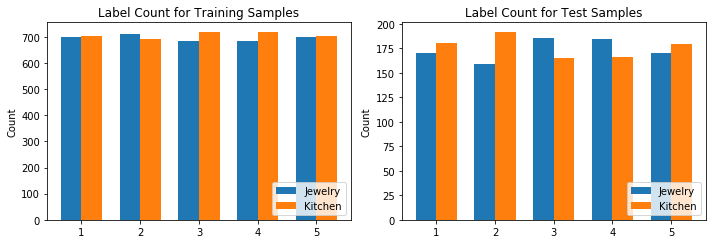

In [20]:
# Creating groups for the graph
groups = list(range(6))[1:]
j_train = []
k_train = []
j_test = []
k_test = []
# 0 = Jewelry
# 1 = Kitchen

# Populating the groups with label counts
for i in range(5):
    j_train.append(dict(pd.Series(y_train[i]).value_counts())[0])
    k_train.append(dict(pd.Series(y_train[i]).value_counts())[1])
    j_test.append(dict(pd.Series(y_test[i]).value_counts())[0])
    k_test.append(dict(pd.Series(y_test[i]).value_counts())[1])

# Initializing the plot
x = np.arange(len(groups))
width = 0.35
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))

# Plot for Train set
ax[0].bar(x - width/2, j_train, width, label='Jewelry')
ax[0].bar(x + width/2, k_train, width, label='Kitchen')
ax[0].set_ylabel('Count')
ax[0].set_title('Label Count for Training Samples')
ax[0].set_xticks(x)
ax[0].set_xticklabels(groups)
ax[0].legend(loc=4)

# Plot for Test set
ax[1].bar(x - width/2, j_test, width, label='Jewelry')
ax[1].bar(x + width/2, k_test, width, label='Kitchen')
ax[1].set_ylabel('Count')
ax[1].set_title('Label Count for Test Samples')
ax[1].set_xticks(x)
ax[1].set_xticklabels(groups)
ax[1].legend(loc=4)
fig.tight_layout()

### Inference
- Our label distribution appears to be uniform (approx).
- Since this distribution of labels portrays a more real and practical scenario, we are not performing a stratified K-Fold CV.

# Part B -  Data Vectorization & Modelling Functions

## B.1. TF-IDF Vectorizer
- We are using the SK Learn implementation of the TF-Idf vectorizer. It can also be integrated with LIME.

In [21]:
# Defining TF-IDF Vectorizer
# Mapping Function - Takes the two dataframes and column
def tfIdfVectors(train, test, coln):
    vectorizer = TfidfVectorizer()
    # Fitting & transforming the vectorizer with train data
    train = vectorizer.fit_transform(train[coln].values.tolist()).toarray()
    # Transforming the test data
    test = vectorizer.transform(test[coln].values.tolist()).toarray()
    feats = vectorizer.get_feature_names()
    return train, test, feats, vectorizer

## B.2. FastText Word Embeddings
- Using the pre-trained FastText embeddings 'wiki-news-300d-1M.vec.zip'.
- Number of Features: 300

### Filtering Word Embeddings
- We are getting at least some or all the word vectors for the dataset corpus (because we are using pre-trained embeddings). Its saved in a dictionary.
- Some out of vocabulary words are ignored. However, we can also perform a mean imputation for such vectors as well.
- If we were training a live Word2Vec model, then we would've had to train the Word2Vec model for each of the training set from K-Fold CV.

In [22]:
# Obtain the corpus for the complete dataset
corpus = X_data['tokens_all'].values.tolist()
corpus = list([i for doc in corpus for i in doc])
# Count the occurences of each token
corpusCount = defaultdict(int)
for i in corpus:
    corpusCount[i]+=1
# Count the tokens with common number of occurences
freqCount = defaultdict(int)
for i in corpusCount.values():
    freqCount[i]+=1
# Get corpus size 
corpus = list(set(corpus))
print('Corpus Size: ', len(corpus))

# Filter the embeddings for the words present in our corpus
embeddings_corpus = {}
# List of embeddings that aren't found
embeddings_not_found =[]
for i in corpus:
    if i not in embeddings_index_all:
        embeddings_not_found.append(i)
    else:
        embeddings_corpus[i] = embeddings_index_all[i]

Corpus Size:  6927


### Simple Average - FastText Embeddings - Sentence Vectors
- Sentence vector is obtained by averaging the word vectors.
- The dataset corpus words that are out of FastText vocabulary are ignored. 
- We can try to ***lemmatize or stem the not found words*** and then search them again in the FastText vocabulary. 
    - But proper testing must be performed for this approach due to conflicting stemmed words.
    - Since, we had high accuracy even without this additional step, we did not perform lemmatization.

In [23]:
# Vectorizing function that returns sentence vector
# Mapping Function - Takes list of tokens for each doc
vectorSize = 300
def docVectorsAvg(tokens):
    sentVecs = []
    # For each token in tokens list
    for i in tokens:
        # Append the corresponding embeddings to a new list
        if i in embeddings_corpus:
            sentVecs.append(embeddings_corpus[i])
    if len(sentVecs) != 0:
        # If  there are word embeddings for the tokens in the doc, then mean of the sentence vectors is returned
        sentVecs = np.mean(sentVecs, axis=0)
    else:
        # If no words are present in the vocabulary, then a zero vector can be returned 
        sentVecs = np.asarray([0.0]*vectorSize, dtype='float32')
    return sentVecs


### TF-IDF Weighted Average - FastText Embeddings - Sentence Vectors
- The sentence vector is calculated by taking the weighted average of the word embeddings with tfidf scores of individual tokens in the given document.
- I.e. For each token of a sentence, its embeddings are multiplied by the tfidf score. An the average sentence vector is obtained by taking weighted average of all the found tokens.
- Missing words are ignored

In [24]:
# Vectorizing function that returns centence vector for every document in the dataset 
vectorSize = 300
# The tfidf transformed training/test dataset and list of features must be fed to this function to map the tfidf weights
def docVectorsTfIdf(data, tfidf, tfidf_feat):
    allVecs = []
    weightSum = 0
    # Iterate on the test/train dataset
    for row, tokens in data.iteritems():
        wordVecs = []
        # Iterate over the doc tokens
        for i in tokens:
            # If the token is in the embeddings and in tf-idf features then we calculate the 
            if (i in embeddings_corpus) and i in tfidf_feat:
                wV = embeddings_corpus[i]
                tfidf_score = tfidf[row][tfidf_feat.index(i)]
                wordVecs.append(wV * tfidf_score)
                weightSum += tfidf_score
        if len(wordVecs) != 0:
            # Mean of the sentence vectors is returned
            allVecs.append(np.sum(wordVecs, axis = 0) / weightSum)
        else:
            # If no words are present in the vocabulary, then a zero vector can be returned 
            allVecs.append(np.asarray([0.0]*vectorSize, dtype='float32'))
    return np.asarray(allVecs)

## B.3. Random Forest Classifier
- The Random Forest Classifier with atleast 10 estimators is good for performing predictions on our data.
- Testing with as high as 100 estimators was also performed. The results were nearly the same.
- In Random Forest classifiers, the accuracy cannot be improved beyond a certain point just by increasing the number of estimators.
- 25 estimators are giving good results across all 5-folds of the test-train split and in much less time.
- It gave high accuracy as compared to Logistic Regression model (~ 98-99% when used with Tf-Idf vectors).

In [25]:
def applyRandomForest(setId, X_train, X_test, y_train, y_test, estimators, printCM, printCR):
    # Define the classifier
    classifier = RandomForestClassifier(n_estimators=estimators, random_state=0, criterion='gini')
    # Fit the model with labeled training data
    classifier.fit(X_train, y_train) 
    # Then predict on the test data
    y_pred = classifier.predict(X_test)
    # Accuracy & F1 score have also been calculated for the classifications
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')
    # Print metrics
    print('Train-Test Split ', setId)
    print('F1 Score: ',f1)
    print('Model Accuracy: ', accuracy)
    if printCM:
        print('Confusion Matrix:\n', confusion_matrix(y_test,y_pred))
    if printCR:
        print('Classification Report:\n', classification_report(y_test,y_pred))
    return (y_pred, classifier, accuracy, f1)

## B.4. Logistic Regression Classifier
- The Logistic Regression model gave the most easily interpretable LIME explanations. That's why the default classifier used in this notebook is Logistic Regression.
- The accuracy was almost as good as the Random Forest Classifier (~98% when used with Tf-Idf vectors)

In [26]:
def applyLogisticRegression(setId, X_train, X_test, y_train, y_test, printCM, printCR):
    # Define the classifier
    classifier = LogisticRegression(solver='lbfgs')
    classifier.fit(X_train, y_train) 
    # Then predict on the test data
    y_pred = classifier.predict(X_test)
    # Accuracy & F1 score have also been calculated for the classifications
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')
    # Print metrics
    print('Train-Test Split ', setId)
    print('F1 Score: ',f1)
    print('Model Accuracy: ', accuracy)
    if printCM:
        print('Confusion Matrix:\n', confusion_matrix(y_test,y_pred))
    if printCR:
        print('Classification Report:\n', classification_report(y_test,y_pred))
    return (y_pred, classifier, accuracy, f1)

## B.5. LIME Explanations
- LIME is a great library for validating the results of our binary classification model using text data.
- It provides us the list of most significant features that contributed towards the classification of a document. It gives the probability of the document to be in either class.

**NOTE:** LIME Explanation has been performed only for TF-Idf Vectorization and not the Word Embedding Vectors. Its because LIME requires an SK Learn pipeline to give explanations. And SK Learn pipeline only supports SK Learn Transformers or custom tansformers that are inherited from the SKLearn libray.

### Custom Sci Kit Learn Transformer to impute Ratings in SKLearn Pipeline
1. This transformer is ONLY used in LIME explainer as LIME only supports SK Learn pieplines.
2. For classification, the ratings have been added to the feature set using map (using numpy).

In [27]:
# Custom transformer to pad the Ratings feature with rowRating (global variable) for SK learn pipeline
class RatingImputer( BaseEstimator, TransformerMixin ):
    # Class Constructor 
    def __init__( self): 
        pass
    # Fit method - returns self    
    def fit( self, X):
        return self 
    # Transform method - convert sparse matrix to 2D, then imputes values and converts 2D back to sparse
    def transform( self, X):
        rows = X.toarray().shape[0]
        #print(sparse.csr_matrix(np.append(X.toarray(), [[0]]*rows, 1)))
        return sparse.csr_matrix(np.append(X.toarray(), [[rowRating]]*rows, 1))
# Custom transformer object
ratingImputer = RatingImputer()
#ratingImputer.transform(sparse.csr_matrix([1,2,3])).toarray()

### LIME Explainer

The SK Learn pieline used to obtain explanations is composed of:
- Tf-Idf Vectorizer
- 'Ratings' Imputer
- Classification Model (Logistic regression or Random Forest)


In [28]:
# Defining the class names (it is index sensitive)
class_names = ['Jewelry', 'Kitchen']
# Defining the LIME explainer function
def explainLIME(ttset, idx, vectorizer, model, num_feats):
    # Defining the SK Learn pipeline
    c = make_pipeline(vectorizer, ratingImputer, model)
    #c = make_pipeline(vectorizer, model)
    # Initializing the explainer
    explainer = LimeTextExplainer(class_names=class_names)
    # Performing explanation for some test document. The cleaned string is used as input for this 
    exp = explainer.explain_instance(X_test_data[ttset]['strings_all'][idx], c.predict_proba, num_features=num_feats)
    # Print explanations & stats
    print('Document ID: %d' % X_test_data[ttset]['index'][idx])
    print('Probability(Jewelry) =', c.predict_proba([X_test_data[ttset]['strings_all'][idx]])[0,0])
    print('Probability(Kitchen) =', c.predict_proba([X_test_data[ttset]['strings_all'][idx]])[0,1])
    print('True class: %s' % class_names[y_test[ttset][idx]])
    #print(exp.as_list())
    return exp

# Part C -  Data Modelling

## Experiment 0 - Training Word2Vec
Before using the FastText Word Embeddings, I experimented with training a **Word2Vec** model. The results were extremely skewed. 
- 98-99% data was classified into a single class.
- It was due to the lack of training data.
- The presence of roughly 2 (single occurence words = 3411, single docs=1754) distinct words per document contributed towards such a skew. There wasn't enough support for such a variety of words.
- The following plot shows the frequency of the various number of word occurences. We can note that in a corpus of size 6927, there are 3411 words that occur only once. Hence, this is the reason for the failure of Word2Vec on the given dataset

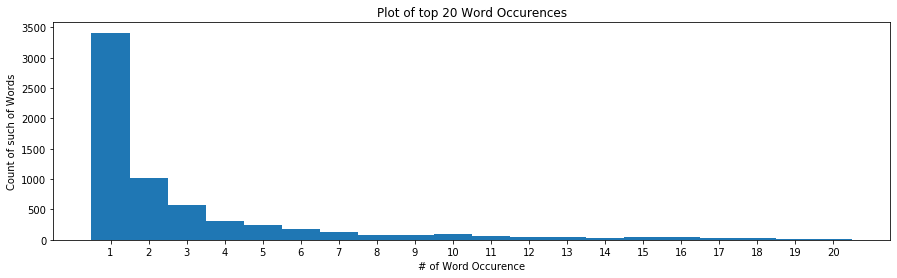

In [29]:
# Plot for showing the frequency distribution
freqTuples = list(zip(freqCount.keys(), freqCount.values()))
# print(freqTuples[:20])
freqTuples.sort(key=lambda x: x[0])
freq, counts = zip(*freqTuples[:20])
# Bar graph
y_pos = np.arange(len(freq))
plt.figure(figsize=(15,4))
plt.bar(y_pos, counts, align='center', width=1)
plt.xticks(y_pos, freq)
plt.ylabel('Count of such of Words')
plt.xlabel('# of Word Occurence')
plt.title('Plot of top 20 Word Occurences')
plt.show()

## MODEL CONFIGURATIONS
Change the values for the below flags to print the different metrics for the classifier.
- Choose the classification model
    - **'classificationModel' = 0** # RandomForest
    - **'classificationModel' = 1** # Logistic Regression
- Change number of estimators/trees in Random Forest
    - **'estimators'** # integer value
- To print the confusion matrix change the flag 
    - **'printCM' = True** # Prints the CM
    - **'printCM' = False** # Doesnt print the CM
- To print the classification report (precision, recall etc.) change the flag 
    - **'printCR' = True** # Prints the CR
    - **'printCR' = False** # Doesn't print the CR

These flags are common for all the experiments.

In [30]:
# Model - Random Forest = 0; logistic Regression = 1
classificationModel = 1
# Estimators
estimators = 25
# Print Confusion Matrix
printCM = True
# Print Classification Report
printCR = False

## Experiment 1 -  TFIDF Vectorizer + Logistic Regression (or Random Forest Classifier)

- TfIdf Vectorizr is applied on the text data in (product_title, review) columns.
- Scaled data from (rating) columns is appended to the list of features.
- **Logistic Regression** model is used for this experiment.

### Observation - Logistic Regression
- Average F1 Score of 98.36% is seen across all 5 dataset splits.
- There is very low variance in scores thus ours splits are similarly distributed.

### Observation - Random Forest
- Average F1 Score of 98.23% is seen across all 5 dataset splits.

In [31]:
X_train_1 = []
X_test_1 = []
y_pred_1 = []
models_1 = []
vectorizer_1 = []
accuracy_1 = 0
f1_1 = 0
for i in range(5):
    # Get Tf-Idf Vectors
    X_train, X_test, tfidf_feats, vect = tfIdfVectors(X_train_data[i], X_test_data[i], 'strings_all')
    
    # Add normalized 'ratings' to train data
    rating_train = list(map(lambda x: [x], X_train_data[i]['rating'].values.tolist()))
    X_train = np.append(X_train, rating_train, 1)
    # Add normalized 'ratings' to test data
    rating_test = list(map(lambda x: [x], X_test_data[i]['rating'].values.tolist()))
    X_test = np.append(X_test, rating_test, 1)

    # Performing predictions
    if classificationModel == 0:
        pred, model, acc, f1 = applyRandomForest(i+1, X_train, X_test, y_train[i], y_test[i], estimators, printCM, printCR)
    elif classificationModel == 1:
        pred, model, acc, f1 = applyLogisticRegression(i+1, X_train, X_test, y_train[i], y_test[i], printCM, printCR)
    else:
        print('Wrong Model Value')
        break
    # Appending the results to the list of data for this experiment
    X_train_1.append(X_train)
    X_test_1.append(X_test)
    models_1.append(model)
    vectorizer_1.append(vect)
    y_pred_1.append(pred)
    accuracy_1 += acc
    f1_1 += f1
    print('\n')
# Printing the average accuracy
print('Average F1 Score for K-Fold CV: ', f1_1/5)
print('Average Accuracy for K-Fold CV: ', accuracy_1/5)

Train-Test Split  1
F1 Score:  0.9863760217983651
Model Accuracy:  0.9857549857549858
Confusion Matrix:
 [[165   5]
 [  0 181]]


Train-Test Split  2
F1 Score:  0.987146529562982
Model Accuracy:  0.9857549857549858
Confusion Matrix:
 [[154   5]
 [  0 192]]


Train-Test Split  3
F1 Score:  0.9820359281437127
Model Accuracy:  0.9829059829059829
Confusion Matrix:
 [[181   5]
 [  1 164]]


Train-Test Split  4
F1 Score:  0.9793510324483776
Model Accuracy:  0.98005698005698
Confusion Matrix:
 [[178   7]
 [  0 166]]


Train-Test Split  5
F1 Score:  0.9835164835164836
Model Accuracy:  0.9828571428571429
Confusion Matrix:
 [[165   5]
 [  1 179]]


Average F1 Score for K-Fold CV:  0.9836851990939841
Average Accuracy for K-Fold CV:  0.9834660154660154


### LIME Explanations
- Due to such a high degree of accuracy, its important that we should get explanation of the various classifications.
- Below is the explanation for the misclassifications. Only top 10 explanations are shown in the plots. Number of explanations can be changed using the below configurations.

### LIME CONFIGURATIONS
- Choose the K-Fold splits for misclassification explanation.
    - **dataSplits** = list with values in range [0,1,2,3,4]
- Choose the number of explanations
    - **explanations** = integer values

In [32]:
# List of K-Fold splits to be used for explanation
dataSplits = [0,1,2,3,4] # MIN=0 & MAX=4
# Number of explanations
explanations = 10

--------------------------
Split 1 Misclassifications
--------------------------
Document ID: 6
Probability(Jewelry) = 0.3844861684482783
Probability(Kitchen) = 0.6155138315517217
True class: Jewelry
Predicted class:  Kitchen
Document ID: 98
Probability(Jewelry) = 0.4834783485618259
Probability(Kitchen) = 0.5165216514381741
True class: Jewelry
Predicted class:  Kitchen
Document ID: 101
Probability(Jewelry) = 0.47506336173216446
Probability(Kitchen) = 0.5249366382678355
True class: Jewelry
Predicted class:  Kitchen
Document ID: 183
Probability(Jewelry) = 0.4725258889230901
Probability(Kitchen) = 0.5274741110769099
True class: Jewelry
Predicted class:  Kitchen
Document ID: 302
Probability(Jewelry) = 0.40533534203086863
Probability(Kitchen) = 0.5946646579691314
True class: Jewelry
Predicted class:  Kitchen


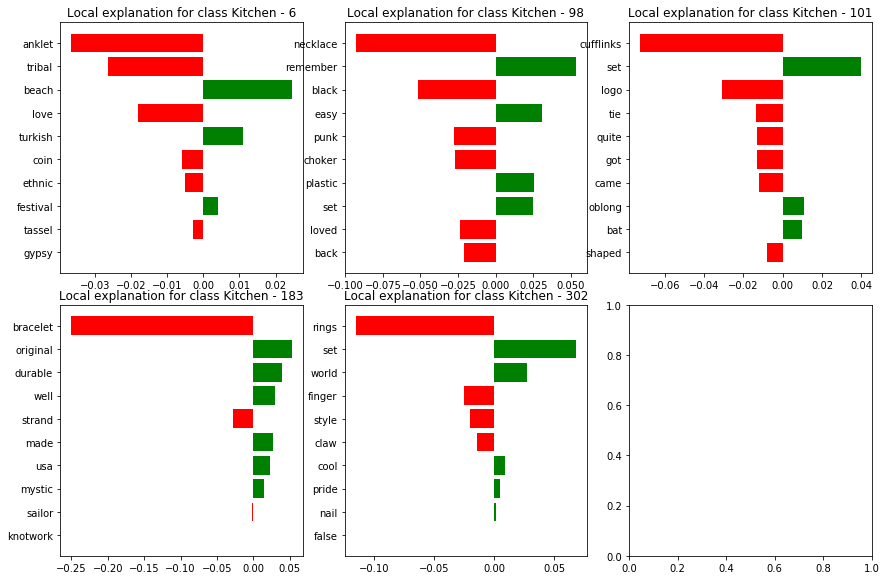

--------------------------
Split 2 Misclassifications
--------------------------
Document ID: 462
Probability(Jewelry) = 0.42300723880166624
Probability(Kitchen) = 0.5769927611983338
True class: Jewelry
Predicted class:  Kitchen
Document ID: 525
Probability(Jewelry) = 0.4441761788952686
Probability(Kitchen) = 0.5558238211047314
True class: Jewelry
Predicted class:  Kitchen
Document ID: 534
Probability(Jewelry) = 0.4848368886452904
Probability(Kitchen) = 0.5151631113547096
True class: Jewelry
Predicted class:  Kitchen
Document ID: 632
Probability(Jewelry) = 0.4042886027142498
Probability(Kitchen) = 0.5957113972857502
True class: Jewelry
Predicted class:  Kitchen
Document ID: 634
Probability(Jewelry) = 0.4241845223075109
Probability(Kitchen) = 0.5758154776924891
True class: Jewelry
Predicted class:  Kitchen


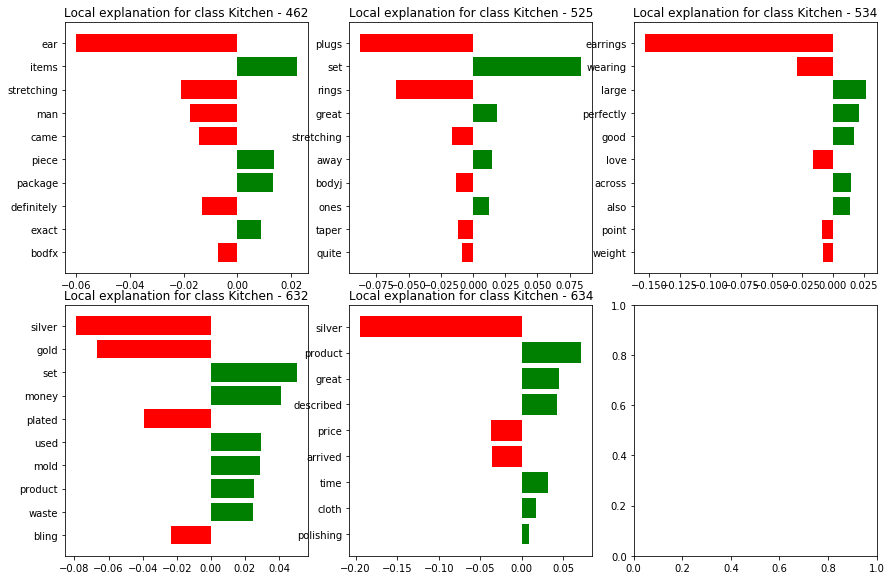

--------------------------
Split 3 Misclassifications
--------------------------
Document ID: 754
Probability(Jewelry) = 0.5979070198818923
Probability(Kitchen) = 0.4020929801181077
True class: Kitchen
Predicted class:  Jewelry
Document ID: 769
Probability(Jewelry) = 0.42497778326184366
Probability(Kitchen) = 0.5750222167381563
True class: Jewelry
Predicted class:  Kitchen
Document ID: 784
Probability(Jewelry) = 0.26125347849804437
Probability(Kitchen) = 0.7387465215019556
True class: Jewelry
Predicted class:  Kitchen
Document ID: 974
Probability(Jewelry) = 0.46018192435385474
Probability(Kitchen) = 0.5398180756461453
True class: Jewelry
Predicted class:  Kitchen
Document ID: 1032
Probability(Jewelry) = 0.2900104663576707
Probability(Kitchen) = 0.7099895336423293
True class: Jewelry
Predicted class:  Kitchen
Document ID: 1040
Probability(Jewelry) = 0.39430458179897854
Probability(Kitchen) = 0.6056954182010215
True class: Jewelry
Predicted class:  Kitchen


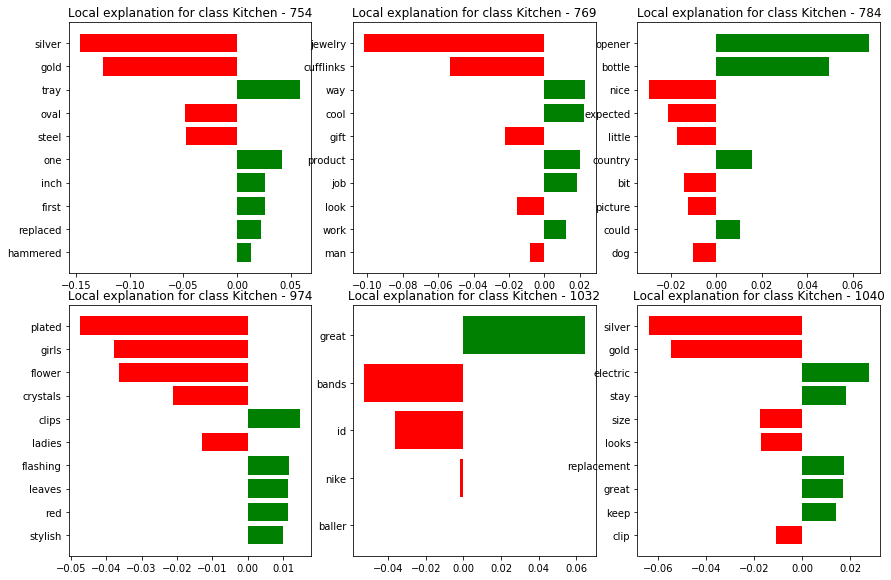

--------------------------
Split 4 Misclassifications
--------------------------
Document ID: 1059
Probability(Jewelry) = 0.43853152200204304
Probability(Kitchen) = 0.561468477997957
True class: Jewelry
Predicted class:  Kitchen
Document ID: 1085
Probability(Jewelry) = 0.47136845351912426
Probability(Kitchen) = 0.5286315464808757
True class: Jewelry
Predicted class:  Kitchen
Document ID: 1248
Probability(Jewelry) = 0.34299956004161136
Probability(Kitchen) = 0.6570004399583886
True class: Jewelry
Predicted class:  Kitchen
Document ID: 1301
Probability(Jewelry) = 0.45588556757811427
Probability(Kitchen) = 0.5441144324218857
True class: Jewelry
Predicted class:  Kitchen
Document ID: 1337
Probability(Jewelry) = 0.38579762054468125
Probability(Kitchen) = 0.6142023794553187
True class: Jewelry
Predicted class:  Kitchen
Document ID: 1343
Probability(Jewelry) = 0.4770020682151793
Probability(Kitchen) = 0.5229979317848207
True class: Jewelry
Predicted class:  Kitchen
Document ID: 1402
Probabili

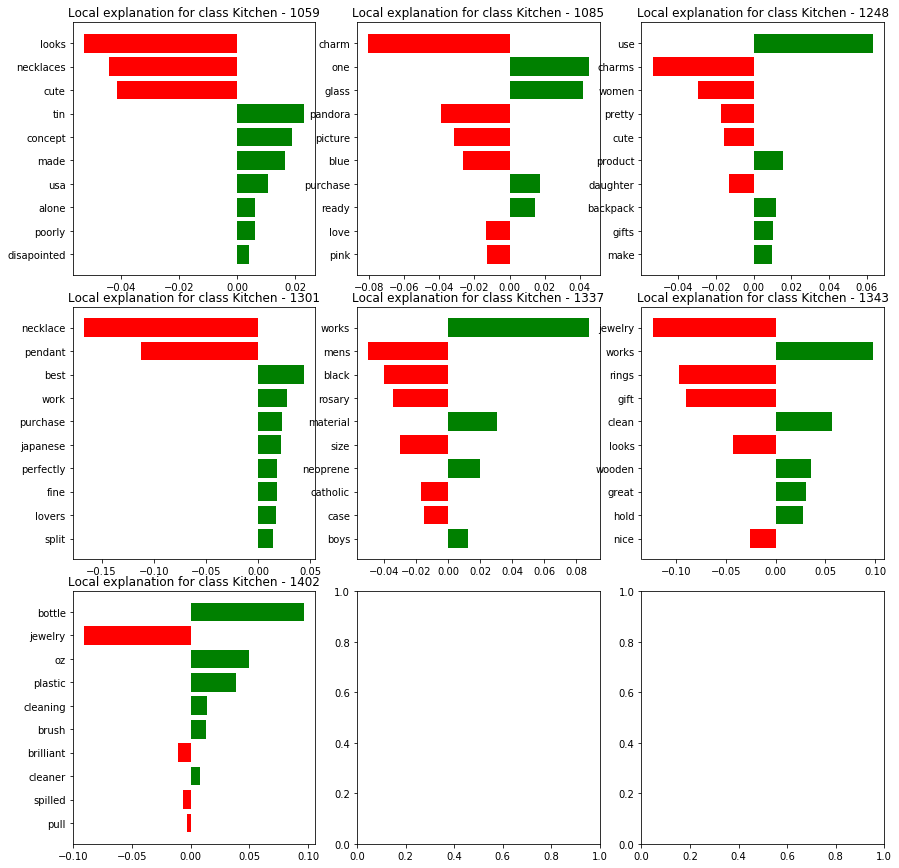

--------------------------
Split 5 Misclassifications
--------------------------
Document ID: 1442
Probability(Jewelry) = 0.4855897895729071
Probability(Kitchen) = 0.5144102104270929
True class: Jewelry
Predicted class:  Kitchen
Document ID: 1518
Probability(Jewelry) = 0.3521405633604635
Probability(Kitchen) = 0.6478594366395365
True class: Jewelry
Predicted class:  Kitchen
Document ID: 1531
Probability(Jewelry) = 0.4902744213956507
Probability(Kitchen) = 0.5097255786043493
True class: Jewelry
Predicted class:  Kitchen
Document ID: 1539
Probability(Jewelry) = 0.6055171570091138
Probability(Kitchen) = 0.3944828429908862
True class: Kitchen
Predicted class:  Jewelry
Document ID: 1623
Probability(Jewelry) = 0.45077176191939927
Probability(Kitchen) = 0.5492282380806007
True class: Jewelry
Predicted class:  Kitchen
Document ID: 1634
Probability(Jewelry) = 0.48283834201262754
Probability(Kitchen) = 0.5171616579873725
True class: Jewelry
Predicted class:  Kitchen


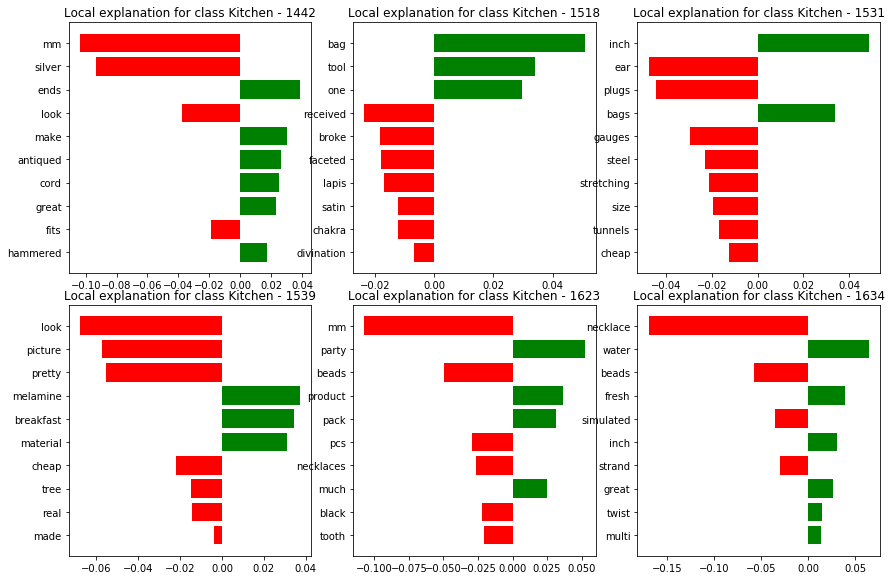

In [33]:
# Function to plot the graph in a grid
def explainerGraph(plotCnt, exp, docid):
    label=1
    exp = exp.as_list(label=1)
    vals = [x[1] for x in exp]
    names = [x[0] for x in exp]
    vals.reverse()
    names.reverse()
    colors = ['green' if x > 0 else 'red' for x in vals]
    title = 'Local explanation for class %s - %s' %(class_names[label], str(docid))
    pos = np.arange(len(exp)) + .5
    ax[plotCnt].barh(pos, vals, align='center', color=colors)
    ax[plotCnt].set_yticks(pos)
    ax[plotCnt].set_yticklabels(names)
    ax[plotCnt].set_title(title)
# Function to get explanations and related stats
def explainMisClasses(ttset, idx, plotCnt, docid):
    global rowRating
    rowRating = X_test_1[ttset][idx][-1]
    exp = explainLIME(ttset, idx, vectorizer_1[ttset], models_1[ttset], explanations)
    print('Predicted class: ', class_names[models_1[ttset].predict([X_test_1[ttset][idx]])[0]])
    explainerGraph(plotCnt, exp, docid)
    # print(exp.as_list())

# Prepare the list of misclassified documents
misclass_1 = []
for i in range(len(y_pred_1)):
    mis = []
    for j in range(len(y_pred_1[i])):
        if y_pred_1[i][j] != y_test[i][j]:
            mis.append([j, y_pred_1[i][j], X_test_data[i]['index'][j]])
    misclass_1.append(mis)
#print(misclass_1)

# Getting Explanations & Plotting them
rowRating = 0
for i in dataSplits:
    print('--------------------------\nSplit %s Misclassifications\n--------------------------' % str(i+1))
    plotRows = int(np.ceil(len(misclass_1[i])/3))
    plotCnt = 0
    fig, ax = plt.subplots(nrows=plotRows, ncols=3, figsize=(12, 4*plotRows))
    fig.tight_layout()
    ax = ax.flatten()
    for j in misclass_1[i]:
        explainMisClasses(i, j[0], plotCnt, j[2])
        plotCnt+=1
    plt.show()

### Observation
- Explanations in red color (left oriented) are contributing towards Jewelry predictions.
- Explanations in green color (right oriented) are contributing towards Kitchen predictions.

### Conclusion
- To increase the probability of correctly classifying the documents misclassified as ***Jewelry***, we can remove the words/explanations in green.
- To increase the probability of correctly classifying the documents misclassified as ***Kitchen***, we can remove the words/explanations in red.
- TfIdf Vectorization works well with both Logistic Regression & the 25 tree Random Forest.
- LIME Explanations for Logistic Regression are very interpretable and are valid. But, for random forest, it appears that the model has high magnitude for Jewelry items as compared to Kitchen. 

### Note:
- To avoid over-fitting the model with the specific words of this dataset, we must take care while selecting the words for removal.
- The frequently used words (with low IDF score) are safer to remove as compared to rarely used words (with high IDF score). Thus, an IDF score based threshold can be used to select the words for removal and improve the model accuracy.

## Experiment 2 -  Simple Average FastText Embeddings + Logistic Regression (or Random Forest Classifier)

- Simple Average of FastText Embeddings is applied to get sentence venctors of the text data in (product_title, review) columns.
- Scaled data from (rating) columns is appended to the list of features.
- **Logistic Regression** model is used for this experiment.

### Observation - Logistic Regression
- Average F1 Score of 98.82% is seen across all 5 dataset splits.

### Observation - Random Forest
- Average F1 Score of 97.46% is seen across all 5 dataset splits.

In [34]:
X_train_2 = []
X_test_2 = []
y_pred_2 = []
models_2 = []
vectorizer_2 = []
accuracy_2 = 0
f1_2 = 0
for i in range(5):
    # Get Tf-Idf Vectors
    X_train = pd.DataFrame(X_train_data[i]['tokens_all'].map(docVectorsAvg).values.tolist(), index= X_train_data[i].index).to_numpy()
    X_test = pd.DataFrame(X_test_data[i]['tokens_all'].map(docVectorsAvg).values.tolist(), index= X_test_data[i].index).to_numpy()
    
    # Add normalized 'ratings' to train data
    rating_train = list(map(lambda x: [x], X_train_data[i]['rating'].values.tolist()))
    X_train = np.append(X_train, rating_train, 1)
    # Add normalized 'ratings' to test data
    rating_test = list(map(lambda x: [x], X_test_data[i]['rating'].values.tolist()))
    X_test = np.append(X_test, rating_test, 1)
    
    # Performing predictions
    if classificationModel == 0:
        pred, model, acc, f1 = applyRandomForest(i+1, X_train, X_test, y_train[i], y_test[i], estimators, printCM, printCR)
    elif classificationModel == 1:
        pred, model, acc, f1 = applyLogisticRegression(i+1, X_train, X_test, y_train[i], y_test[i], printCM, printCR)
    else:
        print('Wrong Model Value')
        break
    # Appending the results to the list of data for this experiment
    X_train_2.append(X_train)
    X_test_2.append(X_test)
    models_2.append(model)
    vectorizer_2.append(vect)
    y_pred_2.append(pred) 
    f1_2 += f1
    accuracy_2 += acc
    print('\n')
# Printing the average accuracy
print('Average F1 Score for K-Fold CV: ', f1_2/5)
print('Average Accuracy for K-Fold CV: ', accuracy_2/5)

Train-Test Split  1
F1 Score:  0.994475138121547
Model Accuracy:  0.9943019943019943
Confusion Matrix:
 [[169   1]
 [  1 180]]


Train-Test Split  2
F1 Score:  0.9820051413881749
Model Accuracy:  0.98005698005698
Confusion Matrix:
 [[153   6]
 [  1 191]]


Train-Test Split  3
F1 Score:  0.9878787878787879
Model Accuracy:  0.9886039886039886
Confusion Matrix:
 [[184   2]
 [  2 163]]


Train-Test Split  4
F1 Score:  0.9880239520958084
Model Accuracy:  0.9886039886039886
Confusion Matrix:
 [[182   3]
 [  1 165]]


Train-Test Split  5
F1 Score:  0.9889502762430938
Model Accuracy:  0.9885714285714285
Confusion Matrix:
 [[167   3]
 [  1 179]]


Average F1 Score for K-Fold CV:  0.9882666591454825
Average Accuracy for K-Fold CV:  0.9880276760276759


### Conclusion
- Simple Average Word Embedding Vectorization works well with both Logistic Regression & the 25 tree Random Forest.
- When applying Logistic Regression, this technique performs better than TfIdf. But, it lags behind when using Random Forest Classifier.
- LIME Explanations cannot be applied to this model without making a customized transformer for word embedding vectorization.

## Experiment 3 -  TF-IDF Weighted Average FastText Embeddings  + Random Forest Classifier

- TFIdf Weighted Average of FastText Embeddings is applied to get sentence venctors of the text data in (product_title, review) columns.
- Scaled data from (rating) columns is appended to the list of features.
- **Logistic Regression** model is used for this experiment.

### Observation - Logistic Regression
- Average F1 Score of 60.81% is seen across all 5 dataset splits.

### Observation - Random Forest
- Average F1 Score of 96.77% is seen across all 5 dataset splits.

In [35]:
X_train_3 = []
X_test_3 = []
y_pred_3 = []
models_3 = []
vectorizer_3 = []
accuracy_3 = 0
f1_3 = 0
for i in range(5):
    # Get Tf-Idf Vectors
    tfidf_train, tfidf_test, tfidf_feats, vect = tfIdfVectors(X_train_data[i], X_test_data[i], 'strings_all')
    
    X_train = docVectorsTfIdf(X_train_data[i]['tokens_all'], tfidf_train, tfidf_feats)
    X_test = docVectorsTfIdf(X_test_data[i]['tokens_all'], tfidf_test, tfidf_feats)
    
    # Add normalized 'ratings' to train data
    rating_train = list(map(lambda x: [x], X_train_data[i]['rating'].values.tolist()))
    X_train = np.append(X_train, rating_train, 1)
    # Add normalized 'ratings' to test data
    rating_test = list(map(lambda x: [x], X_test_data[i]['rating'].values.tolist()))
    X_test = np.append(X_test, rating_test, 1)
    
    # Performing predictions
    if classificationModel == 0:
        pred, model, acc, f1 = applyRandomForest(i+1, X_train, X_test, y_train[i], y_test[i], estimators, printCM, printCR)
    elif classificationModel == 1:
        pred, model, acc, f1 = applyLogisticRegression(i+1, X_train, X_test, y_train[i], y_test[i], printCM, printCR)
    else:
        print('Wrong Model Value')
        break
    # Appending the results to the list of data for this experiment
    X_train_3.append(X_train)
    X_test_3.append(X_test)
    models_3.append(model)
    vectorizer_3.append(vect)
    y_pred_3.append(pred) 
    f1_3 += f1
    accuracy_3 += acc
    print('\n')
# Printing the average accuracy
print('Average F1 Score for K-Fold CV: ', f1_3/5)
print('Average Accuracy for K-Fold CV: ', accuracy_3/5)

Train-Test Split  1
F1 Score:  0.6128266033254156
Model Accuracy:  0.5356125356125356
Confusion Matrix:
 [[ 59 111]
 [ 52 129]]


Train-Test Split  2
F1 Score:  0.6080760095011877
Model Accuracy:  0.5299145299145299
Confusion Matrix:
 [[ 58 101]
 [ 64 128]]


Train-Test Split  3
F1 Score:  0.5909090909090909
Model Accuracy:  0.48717948717948717
Confusion Matrix:
 [[ 41 145]
 [ 35 130]]


Train-Test Split  4
F1 Score:  0.6320346320346321
Model Accuracy:  0.5156695156695157
Confusion Matrix:
 [[ 35 150]
 [ 20 146]]


Train-Test Split  5
F1 Score:  0.5970873786407767
Model Accuracy:  0.5257142857142857
Confusion Matrix:
 [[ 61 109]
 [ 57 123]]


Average F1 Score for K-Fold CV:  0.6081867428822206
Average Accuracy for K-Fold CV:  0.5188180708180707


### Conclusion
- TfIdf Weighted Average Word Embedding Vectorization doesnt work well with Logistic Regression.
- It works well with the 25 tree Random Forest.
- LIME Explanations cannot be applied to this model without making a customized transformer for tfidf-word embedding vectorization.

## OVERALL CONCLUSION
### Feature Selection
- Since we have very less amount of data, we cannot apply a customized and trained Word2Vec implementation.
- The dataset works the best with Tf-Idf vectorization.

### Model
- Random Forest is a better model as it is able to give high accuracy results for a variety of feature vectors
- Logistic Regression gave us more explainable results as compared to Random Forest.

### LIME Explainers
- To avoid over-fitting the model with the specific words of this dataset, we must take care while selecting the words for removal.
- The frequently used words (with low IDF score) are safer to remove as compared to rarely used words (with high IDF score). Thus, an IDF score based threshold can be used to select the words for removal and improve the model accuracy.